In [2]:
import troposkein as tp
import constant as c
import numpy as np
import cv2
import glob
from tqdm import tqdm
import pandas as pd

df_curves = pd.read_pickle('../results/curve.pkl')
df_curves['height'] = df_curves['height'].astype(int)
df_curves['length'] = df_curves['length'].astype(int)
df_curves['speed'] = df_curves['speed'].astype(int)
df_curves['strip'] = df_curves['strip'].astype(int)
df_curves['group'] = df_curves['group'].astype(int)
df_curves['filename'] = df_curves['filename'].astype(str)
df_curves['result'] = df_curves['result'].astype(str)
df_curves['obs_xy_curve'] = df_curves['obs_xy_curve'].to_numpy()
df_curves['obs_x_curve'] = df_curves['obs_x_curve'].to_numpy()
df_curves['obs_y_curve'] = df_curves['obs_y_curve'].to_numpy()
df_curves['obs_x_width'] = df_curves['obs_x_width'].astype(float)
df_curves['obs_y_width'] = df_curves['obs_y_width'].astype(float)
df_curves['est_xy_curve'] = df_curves['est_xy_curve'].to_numpy()
df_curves['est_x_curve'] = df_curves['est_x_curve'].to_numpy()
df_curves['est_y_curve'] = df_curves['est_y_curve'].to_numpy()
df_curves['est_x_width'] = df_curves['est_x_width'].astype(float)
df_curves['est_y_width'] = df_curves['est_y_width'].astype(float)


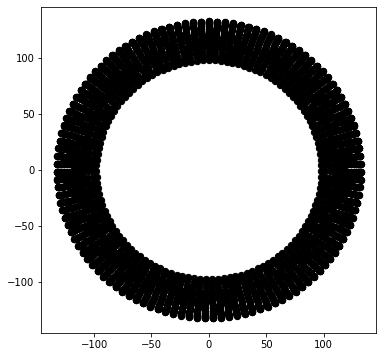

[1.57 0.   0.  ]
[0. 0. 0.]


AssertionError: 

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def _project_pt_to_pixel_location(pt, projection, img_height, img_width):
    _pt = projection.dot(pt)
    if _pt[2] != 0:
        _pt /= _pt[2]
    return np.array([int(-(_pt[0] * img_width) / 2.0 + (img_width * 0.5)), int((_pt[1] * img_height) / 2.0 + (img_height * 0.5)),])

def _project_pt_to_pixel_location_orthographic(pt, projection, img_height, img_width):

# The 'y' component needs to be flipped because of how Unity works

    projection = np.array([
        [projection[0][0], 0, 0],
        [0, -projection[1][1], 0],
        [0, 0, projection[2][2]],
    ])

    temp = projection.dot(pt)

    pixel = [ int((temp[0] + 1) * 0.5 * img_width), int((temp[1] + 1) * 0.5 * img_height)]
    return pixel

for i, row in df_curves.iterrows():
    frame = cv2.imread(row['filename'])
    
    surface_x, surface_y, surface_z, max_diameter, max_vertical_resolution, max_horizontal_resolution, central_tension, extremity_tension =    tp.troposkein3D(
        row['speed'],
        row['length'],
        row['height'],
        c.DEFAULT_HOLE_RADIUS, 
        c.DEFAULT_STRIP_MASS, 
        c.DEFAULT_PIXEL_PITCH, 
        c.DEFAULT_TOP_ROPE_LENGTH_OFFSET, 
        verbose=False
    )
    # axes instance
    fig = plt.figure(figsize=(6,6))
    #ax = Axes3D(fig, auto_add_to_figure=False)
    #fig.add_axes(ax)
    plt.scatter(surface_x, surface_y, s=40, c='black', marker='o', alpha=1)
    plt.show()
    # Define camera matrix
    focal_length = (500, 500)  # assuming equal focal lengths for simplicity
    optical_center = (500, 500)
    camera_matrix = np.array([[focal_length[0], 0, optical_center[0]],
                            [0, focal_length[1], optical_center[1]],
                            [0, 0, 1]], dtype=np.float32)


    # Define distortion coefficients (if any)
    dist_coeffs = np.zeros(5)  # assuming no distortion for simplicity
    # Set up rotation and translation vectors
    rvec = np.array([3.14/2, 0., 0.]) # no rotation
    print(rvec)
    tvec = np.array([0.,0.,1.])  # no translation
    print(tvec)

    # 3D points in world coordinates
    points_3d = np.column_stack((surface_x, surface_y, surface_z)).astype(np.float32)
    # points_3d = np.array([[1, 1, 1],
    #                     [2, 2, 2],
    #                     [3, 3, 3]], dtype=np.float32)

    # Project 3D points to 2D image coordinates
    #point_2d = _project_pt_to_pixel_location(points_3d[0], camera_matrix, frame.shape[0], frame.shape[1])
    #print(point_2d)
    points_2d, _ = cv2.projectPoints(points_3d, rvec, tvec, camera_matrix, dist_coeffs)

    # Display the results
    # for i in range(len(points_3d)):
    #     print(f"3D Point: {points_3d[i]}, 2D Projection: {points_2d[i][0]}")

    # Example: Create an image and draw projected points
    image = np.zeros((1000, 1000, 3), dtype=np.uint8)

    for point in points_2d:
        pt = tuple(map(int, point[0]))
        cv2.circle(image, pt, 5, (0, 255, 0), -1)

    cv2.imshow('Projected Points', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    assert False
    #cv2.imshow('frame', frame)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    